In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 256
N = 500

color_img = []
path = '/content/drive/MyDrive/SAR/colorization/Output_Sorted'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for file in tqdm(files[:N]):
    img = cv2.imread(os.path.join(path, file),1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))

gray_img = []
path = '/content/drive/MyDrive/SAR/colorization/Input_Sorted'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for file in tqdm(files[:N]):
    img = cv2.imread(os.path.join(path, file),1)

    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

100%|██████████| 500/500 [00:14<00:00, 34.55it/s] 


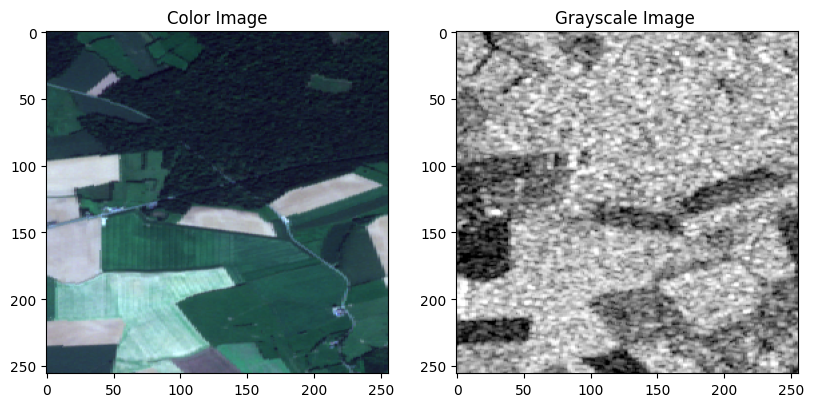

In [4]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)

    plt.show()
plot_images(color_img[0],gray_img[0])

In [5]:
train_gray_image = gray_img[:450]
train_color_image = color_img[:450]

test_gray_image = gray_img[450:]
test_color_image = color_img[450:]

# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (450, 256, 256, 3)
Test color image shape (50, 256, 256, 3)


In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [7]:
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [8]:
model = model()
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        147,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        296,192 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 512)    │      1,182,208 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 8, 8, 512)      │      2,361,856 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 16, 16, 512)    │      2,359,808 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ sequential_5[0][0],    │
│                           │                        │                │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 32, 32, 256)    │      2,359,552 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 512)    │              0 │ sequential_6[0][0],    │
│ (Concatenate)             │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 64, 64, 128)    │        589,952 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 256)    │              0 │ sequential_7[0][0],    │
│ (Concatenate)             │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 128, 128, 128)  │        295,040 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 128, 128, 256)  │              0 │ sequential_8[0][0],    │
│ (Concatenate)             │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 256, 256, 3)    │          6,915 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 256, 256, 6)    │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 3)    │             75 │ concatenate_4[0][0]    │
└──────────────────────

 Total params: 9,602,766 (36.63 MB)

 Trainable params: 9,600,206 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs=50, batch_size=50)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 474ms/step - acc: 0.4712 - loss: 0.4035
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 466ms/step - acc: 0.3339 - loss: 0.2011
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - acc: 0.3483 - loss: 0.1869
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - acc: 0.3402 - loss: 0.1828
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - acc: 0.3481 - loss: 0.1782
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 483ms/step - acc: 0.3383 - loss: 0.1755
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - acc: 0.3505 - loss: 0.1750
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - acc: 0.3437 - loss: 0.1702
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - acc: 0.3558 - loss: 0.1687
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - acc: 0.3669 - loss: 0.1694
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - acc: 0.3771 - loss: 0.1650
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - acc: 0.3623 - loss: 0.1648
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/s

In [10]:
model.evaluate(test_gray_image,test_color_image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - acc: 0.3486 - loss: 0.1523


[0.15453459322452545, 0.34794890880584717]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


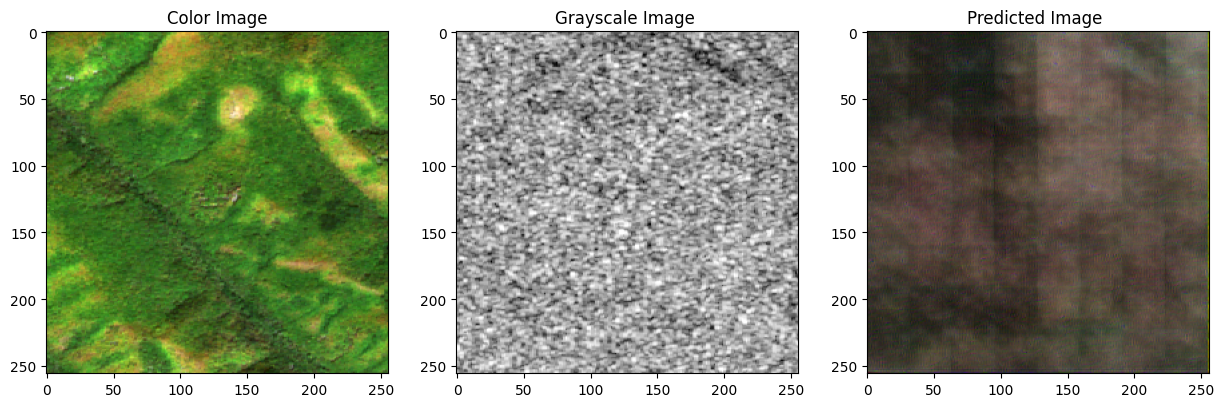

In [11]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ')
    plt.imshow(predicted)

    plt.show()

i = 0
predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(test_color_image[i],test_gray_image[i],predicted)

In [12]:
model.save('/content/drive/MyDrive/SAR/colorization-Autoencoders.keras')